# Lambda Sarsa

Here we added eligibility trace to the SARSA algoritghm. Eligibility trace is, in some sense, closing the gap between SARSA and monte carlo, by making the bootstrap of SARSA less drastic. What we implement here is also called the "backward view of TD($\lambda$)".

The idea is that we track an eligibility trace for each state, action pair $ET(s, a)$. At every episode they start at 0, and every time we select an action $a_0$ in a new state $s_0$ this gets updated by

$$ ET(s,a) \leftarrow \lambda \gamma ET(s,a) \: \: \: \forall (s, a) \neq (s_t, a_t) \in S \times A$$

while for $(s_t, a_t)$ we use one of the following rules

$\textrm{replacing:  } ET(s_t,a_t) \leftarrow 1 $

$\textrm{accumulating:  } ET(s_t,a_t) \leftarrow \lambda \gamma ET(s_t,a_t) + 1 $

$\textrm{dutch:  } ET(s_t,a_t) \leftarrow (1 - \alpha)\lambda \gamma ET(s_t,a_t) + 1 $

Where $\lambda$  is a new hyperparameter. Intuitively this just keeps track of how recently(and often) a state has been visited. 

Using this we can do updates to our $Q$ function not only to $(s_0,a_0)$, but to every state action pair: 
$$\delta = R_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t})$$
$$ Q(s, a) \leftarrow Q(s, a) + \alpha ET(s, a) \delta$$

Then we proced to do everything else just as in the SARSA algorithm.

In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import matplotlib.pyplot as plt
import itertools

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.agents.lambda_sarsa_agent import LambdaSarsaAgent
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action

np.random.seed(21)

In [2]:
gworld = GridWorld(
    grid_shape=(4, 5),
    terminal_states_coordinates=((0, 4),),
    walls_coordinates=((0, 1), (1, 1), (2, 3)),
    traps_coordinates=((1, 3),),
)
print(get_world_str(gworld))

3               

2          █    

1    █     ☠    

0 ⚐  █        ✘ 

  0  1  2  3  4 


In [3]:
def reward(e):
    if e == 1:
        return 0
    elif e == -1:
        return -10
    else:
        return -1

In [4]:
agent = LambdaSarsaAgent(
    world=gworld,
    reward_function=reward,
    actions=[Action.up, Action.down, Action.left, Action.right],
    gamma=1,
    alpha=0.1,
    epsilon=0.1,
)

episode_lengths, episode_returns = agent.train(episodes=500)
pi_r = get_policy_rec(agent.policy, gworld, agent.actions)
print(get_policy_rec_str(pi_r, gworld))

 ↓  →  →  →  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ↑ 

 ↑  █  →  →  ✘ 




Since this agent has some new parameters, lets check how they affect performance. We will examine the "kind" and $\lambda$ values of the eligibility trace. 

In [8]:
def get_results(et_lambda, et_kind, training_rounds=50, episodes=100):

    returns = []
    lengths = []

    for _ in range(training_rounds):

        agent = LambdaSarsaAgent(
            world=gworld,
            reward_function=reward,
            actions=[Action.up, Action.down, Action.left, Action.right],
            gamma=1,
            alpha=0.1,
            epsilon=0.1,
            et_lambda=et_lambda,
            et_kind=et_kind,
        )

        episode_lengths, episode_returns = agent.train(episodes=episodes)
        returns.append(episode_returns)
        lengths.append(episode_lengths)

    pi_r = get_policy_rec(agent.policy, gworld, agent.actions)
    average_returns = np.mean(np.array(returns), axis=0)
    average_lengths = np.mean(np.array(lengths), axis=0)
    return average_returns, average_lengths


results = {
    x: get_results(et_kind=x[0], et_lambda=x[1], training_rounds=50, episodes=100)
    for x in itertools.product(
        ["accumulating", "dutch", "replacing"], [0.2, 0.4, 0.6, 0.8]
    )
}

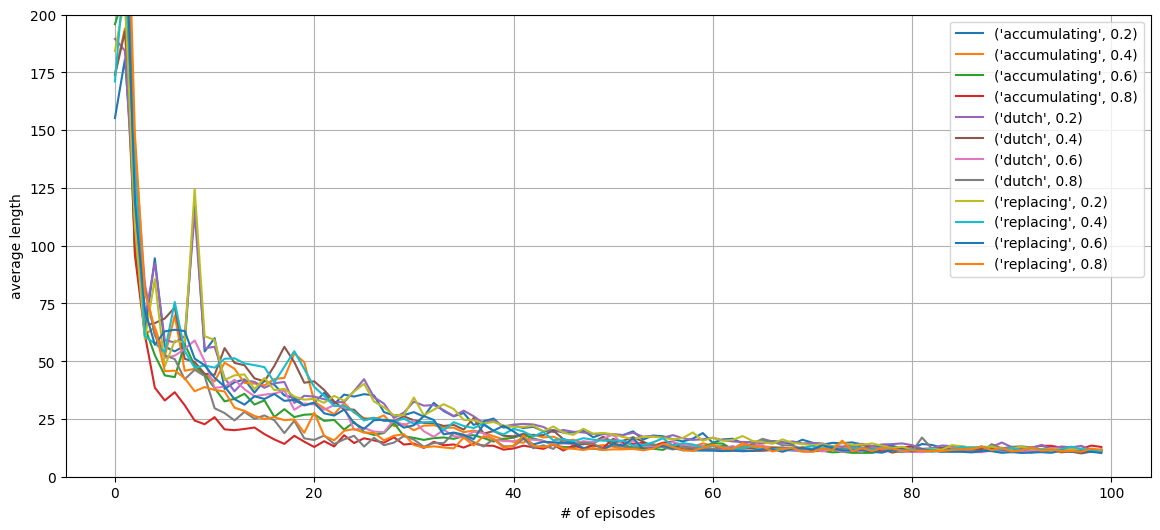

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

for x in results:
    ax.plot(results[x][1], label=f"{x}")

ax.set(xlabel="# of episodes", ylabel="average length", ylim=[0, 200])
ax.grid()
ax.legend(loc="upper right")

plt.show()

In [12]:
print(f"Average accumulated return")
for x in results:
    print(f"{x}: {np.mean(results[x][0]):.2f}")

print(f"\nAverage accumulated return of last 10 episodes")
for x in results:
    print(f"{x}: {np.mean(results[x][0][-10]):.2f}")

Average accumulated return
('accumulating', 0.2): -29.06
('accumulating', 0.4): -25.54
('accumulating', 0.6): -23.07
('accumulating', 0.8): -20.11
('dutch', 0.2): -29.99
('dutch', 0.4): -27.24
('dutch', 0.6): -25.52
('dutch', 0.8): -23.45
('replacing', 0.2): -29.79
('replacing', 0.4): -27.49
('replacing', 0.6): -25.44
('replacing', 0.8): -23.60

Average accumulated return of last 10 episodes
('accumulating', 0.2): -11.38
('accumulating', 0.4): -10.76
('accumulating', 0.6): -11.40
('accumulating', 0.8): -10.54
('dutch', 0.2): -12.18
('dutch', 0.4): -9.76
('dutch', 0.6): -10.70
('dutch', 0.8): -12.48
('replacing', 0.2): -11.74
('replacing', 0.4): -11.76
('replacing', 0.6): -10.22
('replacing', 0.8): -10.28


The new parameters do look to impact performance in a meaningful way.